# Chargement des données

Les données complètes sont disponibles sur le site http://jmcauley.ucsd.edu/data/amazon/links.html. Pour commencer, on se concentre sur des bases de données pour des catégories spécifiques de produit, afin d'avoir une taille raisonnable.

In [146]:
import json
import gzip
import pandas as pd
import numpy as np
import ipywidgets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

Tout d'abord, on sélectionne la base de donnée à étudier:

In [106]:
category_options={
    "Musical Instruments": "reviews_Musical_Instruments.json.gz",
    "Baby": "reviews_Baby.json.gz",
    "Movies and TV": "reviews_Movies_and_TV.json.gz",
}
dropdown = widgets.Dropdown(options=category_options, description="Category of product to study")
display(dropdown)

Ensuite, on décompresse le fichier pour obtenir un fichier en format json

In [107]:
inputFile = gzip.open(dropdown.value, 'rb')
outputFile = open(dropdown.value[:-3], 'wb')
outputFile.write(inputFile.read())
inputFile.close()
outputFile.close()

On la transforme en Pandas DataFrame 

In [108]:
data=[]
filepath=dropdown.value[:-3]
with open(filepath) as f:
    for line in f:
        data.append(json.loads(line))
df=pd.DataFrame(data)

# Analyse descriptive

Regardons la structure de la table:

In [109]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0188399313,"[0, 0]",5,"They work very well. Easy to clean, we wash th...","05 27, 2013",A28O3NP6WR5517,Jennifer gymer,These bottles are great!,1369612800
1,0188399399,"[1, 1]",5,it came early and was not disappointed. i love...,"04 9, 2013",AX0M1Z6ZWO52J,Ash M.,perfect,1365465600
2,0188399518,"[0, 0]",4,I ended up with a variety of different brands ...,"02 14, 2014",A1KD7N84L7NIUT,Buffy Fan,Good cotton wipes,1392336000
3,0188399518,"[1, 1]",3,"These flannel wipes are OK, but in my opinion ...","07 8, 2013",A29CUDEIF4X1UO,J. D. Solbach,Sending them back.,1373241600
4,0316967297,"[0, 0]",4,"Cute quilt, the colors are perfect and my litt...","09 6, 2013",A32592TYN6C9EM,Amazon Customer,Very cute,1378425600


Etudions les dimensions clés de la table:

In [139]:
Nbreviews=len(df)
Nbproducts=len(set(df["asin"]))
print("Le nombre total de reviews est: "+str(Nbreviews))
print("Le nombre total de produits est: "+str(Nbproducts))
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbproducts,1))+ " reviews par produit")

Le nombre total de reviews est: 915448
Le nombre total de produits est: 64426
Soit un nombre moyen de 14.2 reviews par produit


Analysons la distribution des notes des reviews

count    915448.000000
mean          4.117694
std           1.289457
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64


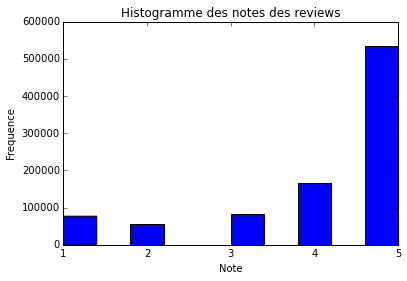

In [171]:
print(df["overall"].describe())
%matplotlib inline 
plt.hist([int(i) for i in df["overall"]]);
plt.title("Histogramme des notes des reviews");
plt.xlabel("Note");
plt.ylabel("Frequence");
plt.xticks(range(1,6));

Regardons la distribution du nombre de reviews par produit

In [ ]:

%matplotlib inline 

plt.hist(df["overall"]);
plt.title("Histogramme des notes des reviews");
plt.xlabel("Note");
plt.ylabel("Frequence");
plt.xticks(range(1,6));

# Préparation des données

In [162]:
import nltk

In [167]:
print(arange(5))

NameError: name 'arange' is not defined